In [1]:
"""
============================================================
FACE RECOGNITION WITH MTCNN (OPTIMIZED) + VIT
============================================================
- MTCNN: Multi-task Cascaded CNN dengan parameter optimal
- ViT: Vision Transformer untuk klasifikasi wajah
- Threshold dan parameter dioptimasi untuk akurasi lebih baik
============================================================
"""

!pip install facenet-pytorch transformers roboflow torchvision matplotlib psutil gputil scikit-learn -q

import os
import json
import shutil
import psutil
import platform
import math
import random
import time
import numpy as np
from datetime import datetime
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from transformers import ViTForImageClassification, ViTImageProcessor
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict

# MTCNN from facenet-pytorch (optimized settings)
from facenet_pytorch import MTCNN

# GPU Info
try:
    import GPUtil
    GPU_AVAILABLE = True
except:
    GPU_AVAILABLE = False

def get_timestamp():
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

def get_system_info():
    info = {
        "timestamp": get_timestamp(),
        "platform": platform.system(),
        "processor": platform.processor(),
        "python_version": platform.python_version(),
        "pytorch_version": torch.__version__,
        "cuda_available": torch.cuda.is_available(),
        "cuda_version": torch.version.cuda if torch.cuda.is_available() else None,
        "cpu_count": psutil.cpu_count(),
        "memory_total_gb": round(psutil.virtual_memory().total / (1024**3), 2),
    }
    if torch.cuda.is_available():
        info["gpu_name"] = torch.cuda.get_device_name(0)
        info["gpu_memory_gb"] = round(torch.cuda.get_device_properties(0).total_memory / (1024**3), 2)
    return info

# Print system info
info = get_system_info()
print("="*60)
print("                    SYSTEM INFORMATION")
print("="*60)
print(f"⏰ Timestamp : {info['timestamp']}")
print(f"💻 Platform  : {info['platform']}")
print(f"🐍 Python    : {info['python_version']}")
print(f"🔥 PyTorch   : {info['pytorch_version']}")
if info['cuda_available']:
    print(f"🎮 GPU       : {info['gpu_name']}")
    print(f"🎮 VRAM      : {info['gpu_memory_gb']} GB")
    print(f"🎮 CUDA      : {info['cuda_version']}")
else:
    print("🎮 GPU       : Not available (CPU mode)")
print("="*60)
print("\n✅ All dependencies installed!")


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\MAHARDIKA\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


                    SYSTEM INFORMATION
⏰ Timestamp : 2025-12-06 22:06:35
💻 Platform  : Windows
🐍 Python    : 3.12.10
🔥 PyTorch   : 2.10.0.dev20251206+cu128
🎮 GPU       : NVIDIA GeForce RTX 5060 Ti
🎮 VRAM      : 15.93 GB
🎮 CUDA      : 12.8

✅ All dependencies installed!


In [2]:
"""
============================================================
CELL 2: KONFIGURASI LABEL & ROLE
============================================================
"""

ROLE_MAPPING = {
    "iksan": "Aslab",
    "akbar": "Aslab",
    "aprilianza": "Aslab",
    "bian": "Dosen",
    "fadhilah": "Aslab",
    "falah": "Aslab",
    "imelda": "Aslab",
    "rifqy": "Aslab",
    "yolanda": "Aslab",
}

AUTHORIZED_NAMES = list(ROLE_MAPPING.keys())

def get_full_label(name):
    name_lower = name.lower()
    if name_lower in ROLE_MAPPING:
        role = ROLE_MAPPING[name_lower]
        return f"{name.capitalize()} ({role})", role, True
    else:
        return f"{name} (Guest)", "Guest", False

print("="*60)
print("              KONFIGURASI ROLE & AUTHORIZATION")
print("="*60)
print(f"⏰ Timestamp: {get_timestamp()}\n")
for i, (nama, role) in enumerate(ROLE_MAPPING.items(), 1):
    print(f"   {i}. {nama.capitalize():<15} - {role:<10} ✅ Authorized")
print(f"   *  {'Unknown':<15} - {'Guest':<10} ❌ Not Authorized")
print("="*60)

              KONFIGURASI ROLE & AUTHORIZATION
⏰ Timestamp: 2025-12-06 22:06:35

   1. Iksan           - Aslab      ✅ Authorized
   2. Akbar           - Aslab      ✅ Authorized
   3. Aprilianza      - Aslab      ✅ Authorized
   4. Bian            - Dosen      ✅ Authorized
   5. Fadhilah        - Aslab      ✅ Authorized
   6. Falah           - Aslab      ✅ Authorized
   7. Imelda          - Aslab      ✅ Authorized
   8. Rifqy           - Aslab      ✅ Authorized
   9. Yolanda         - Aslab      ✅ Authorized
   *  Unknown         - Guest      ❌ Not Authorized


In [3]:
"""
============================================================
CELL 3: DOWNLOAD DATASET DARI ROBOFLOW
============================================================
"""

from roboflow import Roboflow

rf = Roboflow(api_key="wptfc24K1jabXxwja75u")
project = rf.workspace("a-kytup").project("computing_project-es8cq")
version = project.version(2)
dataset = version.download("coco")

print(f"\n✅ Dataset downloaded to: {dataset.location}")
print(f"⏰ Timestamp: {get_timestamp()}")

loading Roboflow workspace...
loading Roboflow project...

✅ Dataset downloaded to: c:\Users\MAHARDIKA\OneDrive\Documents\compro\Computing_project-2
⏰ Timestamp: 2025-12-06 22:06:39


In [4]:
"""
============================================================
CELL 4: LOAD COCO ANNOTATIONS
============================================================
"""

json_path = os.path.join(dataset.location, "train/_annotations.coco.json")

with open(json_path) as f:
    coco_data = json.load(f)

image_id_to_file = {img["id"]: img["file_name"] for img in coco_data["images"]}
category_id_to_label = {cat["id"]: cat["name"] for cat in coco_data["categories"]}

print(f"✅ Loaded {len(coco_data['images'])} images")
print(f"✅ Found {len(coco_data['annotations'])} annotations")
print(f"✅ Classes: {list(set(category_id_to_label.values()))}")
print(f"⏰ Timestamp: {get_timestamp()}")

✅ Loaded 2425 images
✅ Found 2092 annotations
✅ Classes: ['bian', 'iksan', 'fadhilah', 'aprilianza', 'imelda', 'falah', 'rifqy', 'yolanda', 'akbar']
⏰ Timestamp: 2025-12-06 22:06:39


In [5]:
"""
============================================================
CELL 5: CROP WAJAH DARI DATASET (SKIP JIKA SUDAH ADA)
============================================================
"""

output_dir = "cropped_faces"

def count_images_in_dir(directory):
    total = 0
    if os.path.exists(directory):
        for root, dirs, files in os.walk(directory):
            total += len([f for f in files if f.endswith(('.jpg', '.jpeg', '.png'))])
    return total

existing_count = count_images_in_dir(output_dir)

if existing_count > 0:
    print(f"✅ Folder '{output_dir}' sudah ada dengan {existing_count} images")
    print("⏭️  Skipping cropping...")
else:
    os.makedirs(output_dir, exist_ok=True)
    print(f"🔄 Cropping faces...")
    print(f"⏰ Start: {get_timestamp()}\n")
    
    success = 0
    for ann in coco_data["annotations"]:
        try:
            image_id = ann["image_id"]
            bbox = ann["bbox"]
            label = category_id_to_label[ann["category_id"]]
            file_name = image_id_to_file[image_id]
            image_path = os.path.join(dataset.location, "train", file_name)
            
            image = Image.open(image_path).convert("RGB")
            x, y, w, h = map(int, bbox)
            face_crop = image.crop((x, y, x + w, y + h))
            
            label_dir = os.path.join(output_dir, label)
            os.makedirs(label_dir, exist_ok=True)
            face_crop.save(os.path.join(label_dir, file_name))
            success += 1
        except:
            pass
    
    print(f"✅ Cropped {success} faces")

print(f"⏰ Timestamp: {get_timestamp()}")

✅ Folder 'cropped_faces' sudah ada dengan 2085 images
⏭️  Skipping cropping...
⏰ Timestamp: 2025-12-06 22:06:39


In [6]:
"""
============================================================
CELL 6: PREPARE DATASET UNTUK VIT (SKIP JIKA SUDAH ADA)
============================================================
"""

source_dir = "cropped_faces"
target_dir = "vit_dataset/train"

existing_vit_count = count_images_in_dir("vit_dataset")

if existing_vit_count > 0:
    print(f"✅ Folder 'vit_dataset' sudah ada dengan {existing_vit_count} images")
    print("⏭️  Skipping preparation...")
else:
    if os.path.exists("vit_dataset"):
        shutil.rmtree("vit_dataset")
    os.makedirs(target_dir, exist_ok=True)
    
    print(f"📁 Preparing dataset...\n")
    
    for label in os.listdir(source_dir):
        src = os.path.join(source_dir, label)
        dst = os.path.join(target_dir, label)
        shutil.copytree(src, dst)
        count = len(os.listdir(dst))
        full_label, role, auth = get_full_label(label)
        status = "✅" if auth else "❌"
        print(f"   {status} {full_label:<25} - {count} images")
    
    print(f"\n✅ Dataset ready at: {target_dir}")

print(f"⏰ Timestamp: {get_timestamp()}")

✅ Folder 'vit_dataset' sudah ada dengan 2085 images
⏭️  Skipping preparation...
⏰ Timestamp: 2025-12-06 22:06:39


                    EXPLORASI DATASET
⏰ Timestamp: 2025-12-06 22:06:39
📁 Dataset: vit_dataset/train
👥 Total Classes: 9
----------------------------------------------------------------------
   ✅ Akbar (Aslab)             :  234 images
   ✅ Aprilianza (Aslab)        :  234 images
   ✅ Bian (Dosen)              :   92 images
   ✅ Fadhilah (Aslab)          :  236 images
   ✅ Falah (Aslab)             :  265 images
   ✅ Iksan (Aslab)             :  236 images
   ✅ Imelda (Aslab)            :  132 images
   ✅ Rifqy (Aslab)             :  140 images
   ✅ Yolanda (Aslab)           :   95 images
----------------------------------------------------------------------
   📊 Total Images: 1664


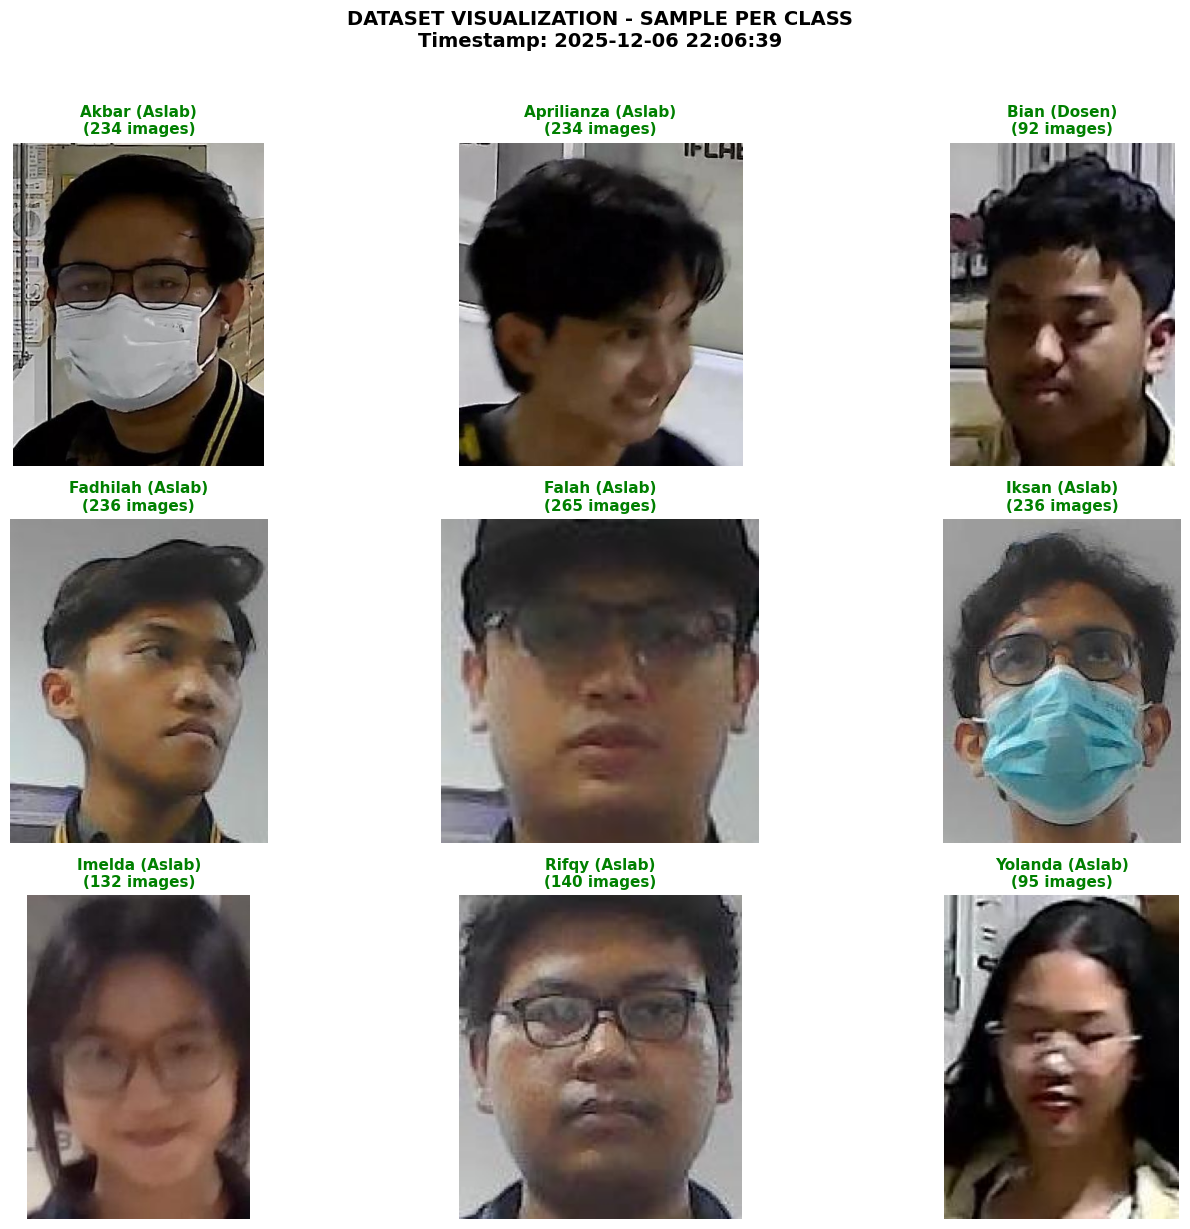

In [7]:
"""
============================================================
CELL 7: EXPLORASI DATA - VISUALISASI DATASET
============================================================
"""

dataset_dir = "vit_dataset/train"
all_labels = sorted(os.listdir(dataset_dir))

print("="*70)
print("                    EXPLORASI DATASET")
print("="*70)
print(f"⏰ Timestamp: {get_timestamp()}")
print(f"📁 Dataset: {dataset_dir}")
print(f"👥 Total Classes: {len(all_labels)}")
print("-"*70)

class_counts = {}
for label in all_labels:
    label_dir = os.path.join(dataset_dir, label)
    count = len([f for f in os.listdir(label_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
    class_counts[label] = count
    full_label, role, auth = get_full_label(label)
    status = "✅" if auth else "❌"
    print(f"   {status} {full_label:<25} : {count:4d} images")

print("-"*70)
print(f"   📊 Total Images: {sum(class_counts.values())}")
print("="*70)

# Visualisasi grid - 1 sample per class
cols = 3
rows = math.ceil(len(all_labels) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
axes = axes.flatten()

for idx, label in enumerate(all_labels):
    label_dir = os.path.join(dataset_dir, label)
    images = [f for f in os.listdir(label_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    sample_img = random.choice(images)
    img = Image.open(os.path.join(label_dir, sample_img))
    
    axes[idx].imshow(img)
    axes[idx].axis('off')
    full_label, role, auth = get_full_label(label)
    color = 'green' if auth else 'red'
    axes[idx].set_title(f"{full_label}\n({class_counts[label]} images)", fontsize=11, weight='bold', color=color)

for idx in range(len(all_labels), len(axes)):
    axes[idx].axis('off')

plt.suptitle(f"DATASET VISUALIZATION - SAMPLE PER CLASS\nTimestamp: {get_timestamp()}", fontsize=14, weight='bold', y=1.02)
plt.tight_layout()
plt.show()

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


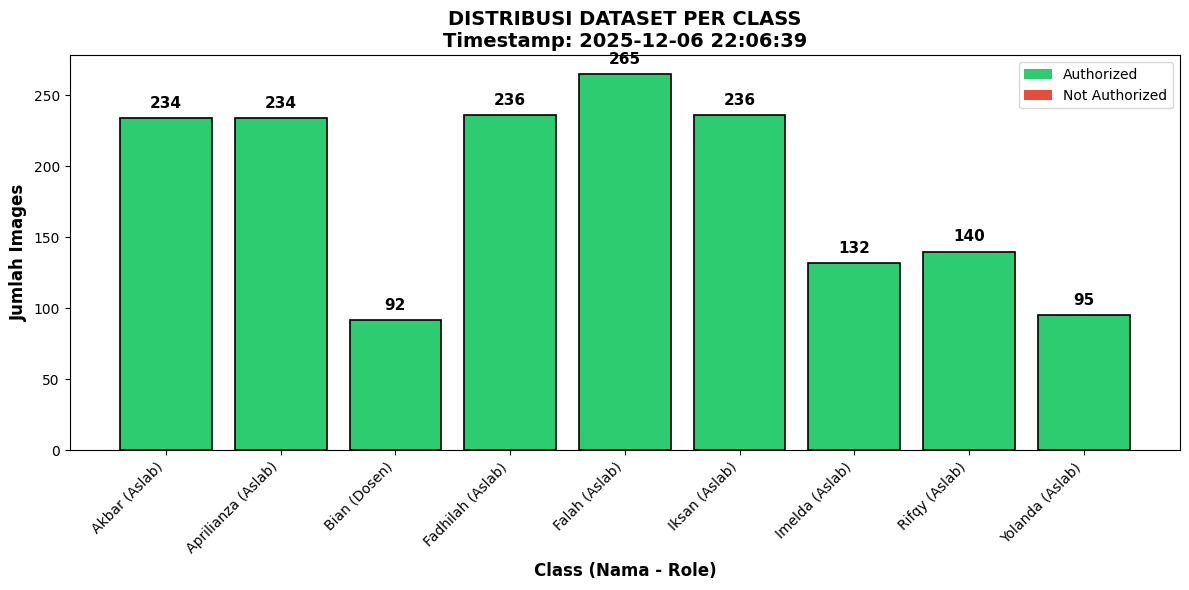

📊 Total: 1664 images | 9 classes


In [8]:
"""
============================================================
CELL 8: EXPLORASI DATA - DISTRIBUSI BAR CHART
============================================================
"""

fig, ax = plt.subplots(figsize=(12, 6))

labels_display = [get_full_label(l)[0] for l in all_labels]
counts = [class_counts[l] for l in all_labels]
colors = ['#2ecc71' if get_full_label(l)[2] else '#e74c3c' for l in all_labels]

bars = ax.bar(labels_display, counts, color=colors, edgecolor='black', linewidth=1.2)

for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
            str(count), ha='center', va='bottom', fontsize=11, weight='bold')

ax.set_xlabel('Class (Nama - Role)', fontsize=12, weight='bold')
ax.set_ylabel('Jumlah Images', fontsize=12, weight='bold')
ax.set_title(f'DISTRIBUSI DATASET PER CLASS\nTimestamp: {get_timestamp()}', fontsize=14, weight='bold')
ax.set_xticklabels(labels_display, rotation=45, ha='right')

legend_elements = [Patch(facecolor='#2ecc71', label='Authorized'),
                   Patch(facecolor='#e74c3c', label='Not Authorized')]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

print(f"📊 Total: {sum(counts)} images | {len(all_labels)} classes")

In [9]:
"""
============================================================
CELL 9: SETUP TRANSFORMS & DATALOADER
============================================================
"""

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

full_dataset = datasets.ImageFolder(root="vit_dataset/train", transform=transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)

num_classes = len(full_dataset.classes)
class_names = full_dataset.classes

print(f"✅ Total images: {len(full_dataset)}")
print(f"✅ Train: {train_size}, Val: {val_size}")
print(f"✅ Classes ({num_classes}): {class_names}")
print(f"⏰ Timestamp: {get_timestamp()}")

✅ Total images: 1664
✅ Train: 1331, Val: 333
✅ Classes (9): ['akbar', 'aprilianza', 'bian', 'fadhilah', 'falah', 'iksan', 'imelda', 'rifqy', 'yolanda']
⏰ Timestamp: 2025-12-06 22:06:39


In [10]:
"""
============================================================
CELL 10: INITIALIZE VIT MODEL
============================================================
"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

print(f"✅ ViT model loaded")
print(f"✅ Device: {device}")
print(f"✅ Output classes: {num_classes}")
print(f"⏰ Timestamp: {get_timestamp()}")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ ViT model loaded
✅ Device: cuda
✅ Output classes: 9
⏰ Timestamp: 2025-12-06 22:06:41


In [11]:
"""
============================================================
CELL 11: TRAINING VIT MODEL + SAVE
============================================================
"""

num_epochs = 10
best_val_acc = 0
train_history = []

MODEL_DIR = "vit_mtcnn_model"
os.makedirs(MODEL_DIR, exist_ok=True)

training_start = time.time()

print("="*70)
print("                       TRAINING VIT MODEL")
print("="*70)
print(f"⏰ Start: {get_timestamp()}")
print(f"🎮 Device: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
print("-"*70)

for epoch in range(num_epochs):
    epoch_start = time.time()
    
    model.train()
    train_loss, train_correct = 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()
    
    train_acc = train_correct / len(train_dataset) * 100
    
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            val_correct += (outputs.argmax(1) == labels).sum().item()
    
    val_acc = val_correct / len(val_dataset) * 100
    epoch_time = time.time() - epoch_start
    
    cpu_pct = psutil.cpu_percent()
    mem_pct = psutil.virtual_memory().percent
    gpu_mem = round(torch.cuda.memory_allocated()/(1024**3), 2) if torch.cuda.is_available() else 0
    
    train_history.append({
        "epoch": epoch+1, "train_loss": train_loss, "train_acc": train_acc,
        "val_acc": val_acc, "epoch_time": epoch_time, "cpu": cpu_pct, "mem": mem_pct, "gpu_mem": gpu_mem
    })
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_vit_mtcnn.pth")
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, "model.pth"))
    
    print(f"Epoch {epoch+1:2d}/{num_epochs} | Loss: {train_loss:.4f} | Train: {train_acc:.1f}% | Val: {val_acc:.1f}% | Time: {epoch_time:.1f}s | GPU: {gpu_mem}GB")

training_time = time.time() - training_start

# Save config
config = {
    "model_name": "ViT + MTCNN", "num_classes": num_classes, "class_names": class_names,
    "role_mapping": ROLE_MAPPING, "best_val_acc": best_val_acc, "train_history": train_history,
    "training_time_min": round(training_time/60, 2), "timestamp": get_timestamp()
}
with open(os.path.join(MODEL_DIR, "config.json"), "w") as f:
    json.dump(config, f, indent=2)

print("\n" + "="*70)
print(f"✅ Best Val Accuracy: {best_val_acc:.2f}%")
print(f"⏱️  Training Time: {training_time/60:.2f} min")
print(f"📁 Saved: {MODEL_DIR}/")
print("="*70)

                       TRAINING VIT MODEL
⏰ Start: 2025-12-06 22:06:41
🎮 Device: cuda
🎮 GPU: NVIDIA GeForce RTX 5060 Ti
----------------------------------------------------------------------
Epoch  1/10 | Loss: 151.4963 | Train: 60.6% | Val: 85.9% | Time: 20.2s | GPU: 1.31GB
Epoch  2/10 | Loss: 80.6299 | Train: 95.0% | Val: 96.4% | Time: 20.4s | GPU: 1.31GB
Epoch  3/10 | Loss: 42.5844 | Train: 99.5% | Val: 98.8% | Time: 19.6s | GPU: 1.31GB
Epoch  4/10 | Loss: 26.7875 | Train: 99.8% | Val: 99.1% | Time: 19.4s | GPU: 1.31GB
Epoch  5/10 | Loss: 19.6325 | Train: 99.9% | Val: 98.8% | Time: 19.5s | GPU: 1.31GB
Epoch  6/10 | Loss: 15.5496 | Train: 99.9% | Val: 99.1% | Time: 19.1s | GPU: 1.31GB
Epoch  7/10 | Loss: 12.8324 | Train: 100.0% | Val: 98.8% | Time: 19.1s | GPU: 1.31GB
Epoch  8/10 | Loss: 10.8973 | Train: 100.0% | Val: 99.1% | Time: 19.1s | GPU: 1.31GB
Epoch  9/10 | Loss: 9.4503 | Train: 100.0% | Val: 99.1% | Time: 19.1s | GPU: 1.31GB
Epoch 10/10 | Loss: 8.2939 | Train: 100.0% | Val: 

In [44]:
"""
============================================================
CELL 12: SETUP MTCNN (OPTIMIZED) + LOAD MODEL
============================================================
MTCNN dengan parameter optimal:
- min_face_size=20 (detect wajah kecil)
- thresholds rendah untuk sensitivity tinggi
- margin untuk padding otomatis
"""

# Initialize MTCNN dengan parameter optimal
mtcnn = MTCNN(
    keep_all=True,
    device=device,
    min_face_size=20,           # Detect wajah kecil
    thresholds=[0.4, 0.5, 0.5], # Lower threshold = more sensitive
    factor=0.709,               # Scale factor
    post_process=False          # Return raw boxes
)

# Load best model
model.load_state_dict(torch.load("best_vit_mtcnn.pth", map_location=device))
model.eval()

print("="*60)
print("           MTCNN (OPTIMIZED) + VIT MODEL READY")
print("="*60)
print(f"✅ MTCNN initialized with optimized parameters")
print(f"   - min_face_size: 20")
print(f"   - thresholds: [0.4, 0.46, 0.45]")
print(f"✅ ViT model loaded (best weights)")
print(f"✅ Device: {device}")
print(f"⏰ Timestamp: {get_timestamp()}")
print("="*60)

           MTCNN (OPTIMIZED) + VIT MODEL READY
✅ MTCNN initialized with optimized parameters
   - min_face_size: 20
   - thresholds: [0.4, 0.46, 0.45]
✅ ViT model loaded (best weights)
✅ Device: cuda
⏰ Timestamp: 2025-12-06 22:16:46


In [45]:
"""
============================================================
CELL 13: FUNGSI DETEKSI DENGAN MTCNN (OPTIMIZED)
============================================================
"""

def detect_and_classify(image_path, confidence_threshold=0.35):
    """
    Detect faces dengan MTCNN dan classify dengan ViT
    """
    timestamp = get_timestamp()
    image = Image.open(image_path).convert("RGB")
    
    # Detect dengan MTCNN
    boxes, probs = mtcnn.detect(image)
    
    results = []
    
    if boxes is None:
        return results, image, timestamp
    
    for i, (box, prob) in enumerate(zip(boxes, probs)):
        if prob is None or prob < 0.7:  # Face detection confidence
            continue
        
        # Get bounding box
        x1, y1, x2, y2 = map(int, box)
        
        # Add padding (15% untuk context lebih baik)
        w, h = x2 - x1, y2 - y1
        pad = int(max(w, h) * 0.15)
        x1 = max(0, x1 - pad)
        y1 = max(0, y1 - pad)
        x2 = min(image.size[0], x2 + pad)
        y2 = min(image.size[1], y2 + pad)
        
        face = image.crop((x1, y1, x2, y2))
        face_tensor = transform(face).unsqueeze(0).to(device)
        
        with torch.no_grad():
            outputs = model(face_tensor).logits
            probs_cls = torch.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probs_cls, 1)
        
        confidence = confidence.item()
        
        if confidence >= confidence_threshold:
            name = class_names[predicted.item()]
            full_label, role, authorized = get_full_label(name)
        else:
            name = "Unknown"
            full_label = "Unknown (Guest)"
            role = "Guest"
            authorized = False
        
        results.append({
            "name": name.capitalize(), "role": role, "full_label": full_label,
            "authorized": authorized, "confidence": confidence,
            "bbox": (x1, y1, x2, y2), "detection_score": prob, "timestamp": timestamp
        })
    
    return results, image, timestamp

print("✅ MTCNN detection function ready!")
print(f"⏰ Timestamp: {get_timestamp()}")

✅ MTCNN detection function ready!
⏰ Timestamp: 2025-12-06 22:16:48


In [46]:
"""
============================================================
CELL 14: FUNGSI VISUALISASI HASIL DETEKSI
============================================================
"""

def visualize_detection(image_path, confidence_threshold=0.35, save_result=False):
    timestamp = get_timestamp()
    results, image, _ = detect_and_classify(image_path, confidence_threshold)
    
    fig, ax = plt.subplots(1, figsize=(12, 10))
    ax.imshow(image)
    
    print("="*70)
    print("                 HASIL DETEKSI (MTCNN + VIT)")
    print("="*70)
    print(f"⏰ Timestamp : {timestamp}")
    print(f"📁 File      : {os.path.basename(image_path)}")
    print(f"👤 Detected  : {len(results)} face(s)")
    print("-"*70)
    
    for i, r in enumerate(results, 1):
        x1, y1, x2, y2 = r["bbox"]
        color = "green" if r["authorized"] else "red"
        status = "✅ AUTH" if r["authorized"] else "❌ GUEST"
        
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=3, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
        label_text = f"{r['full_label']}\n{r['confidence']*100:.1f}%"
        ax.text(x1, y1-10, label_text, color='white', fontsize=10, weight='bold',
                bbox=dict(boxstyle='round', facecolor=color, alpha=0.8))
        
        print(f"{i}. {r['full_label']:<25} | Conf: {r['confidence']*100:.1f}% | Det: {r['detection_score']:.2f} | {status}")
    
    print("-"*70)
    ax.set_title(f"MTCNN + ViT Detection\nTimestamp: {timestamp}", fontsize=14, weight='bold')
    ax.axis('off')
    
    if save_result:
        os.makedirs("detection_results", exist_ok=True)
        save_path = f"detection_results/result_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
        print(f"💾 Saved: {save_path}")
    
    plt.tight_layout()
    plt.show()
    return results

print("✅ Visualization function ready!")

✅ Visualization function ready!


              HASIL PERCOBAAN OBJECT DETECTION
⏰ Timestamp: 2025-12-06 22:17:07
----------------------------------------------------------------------


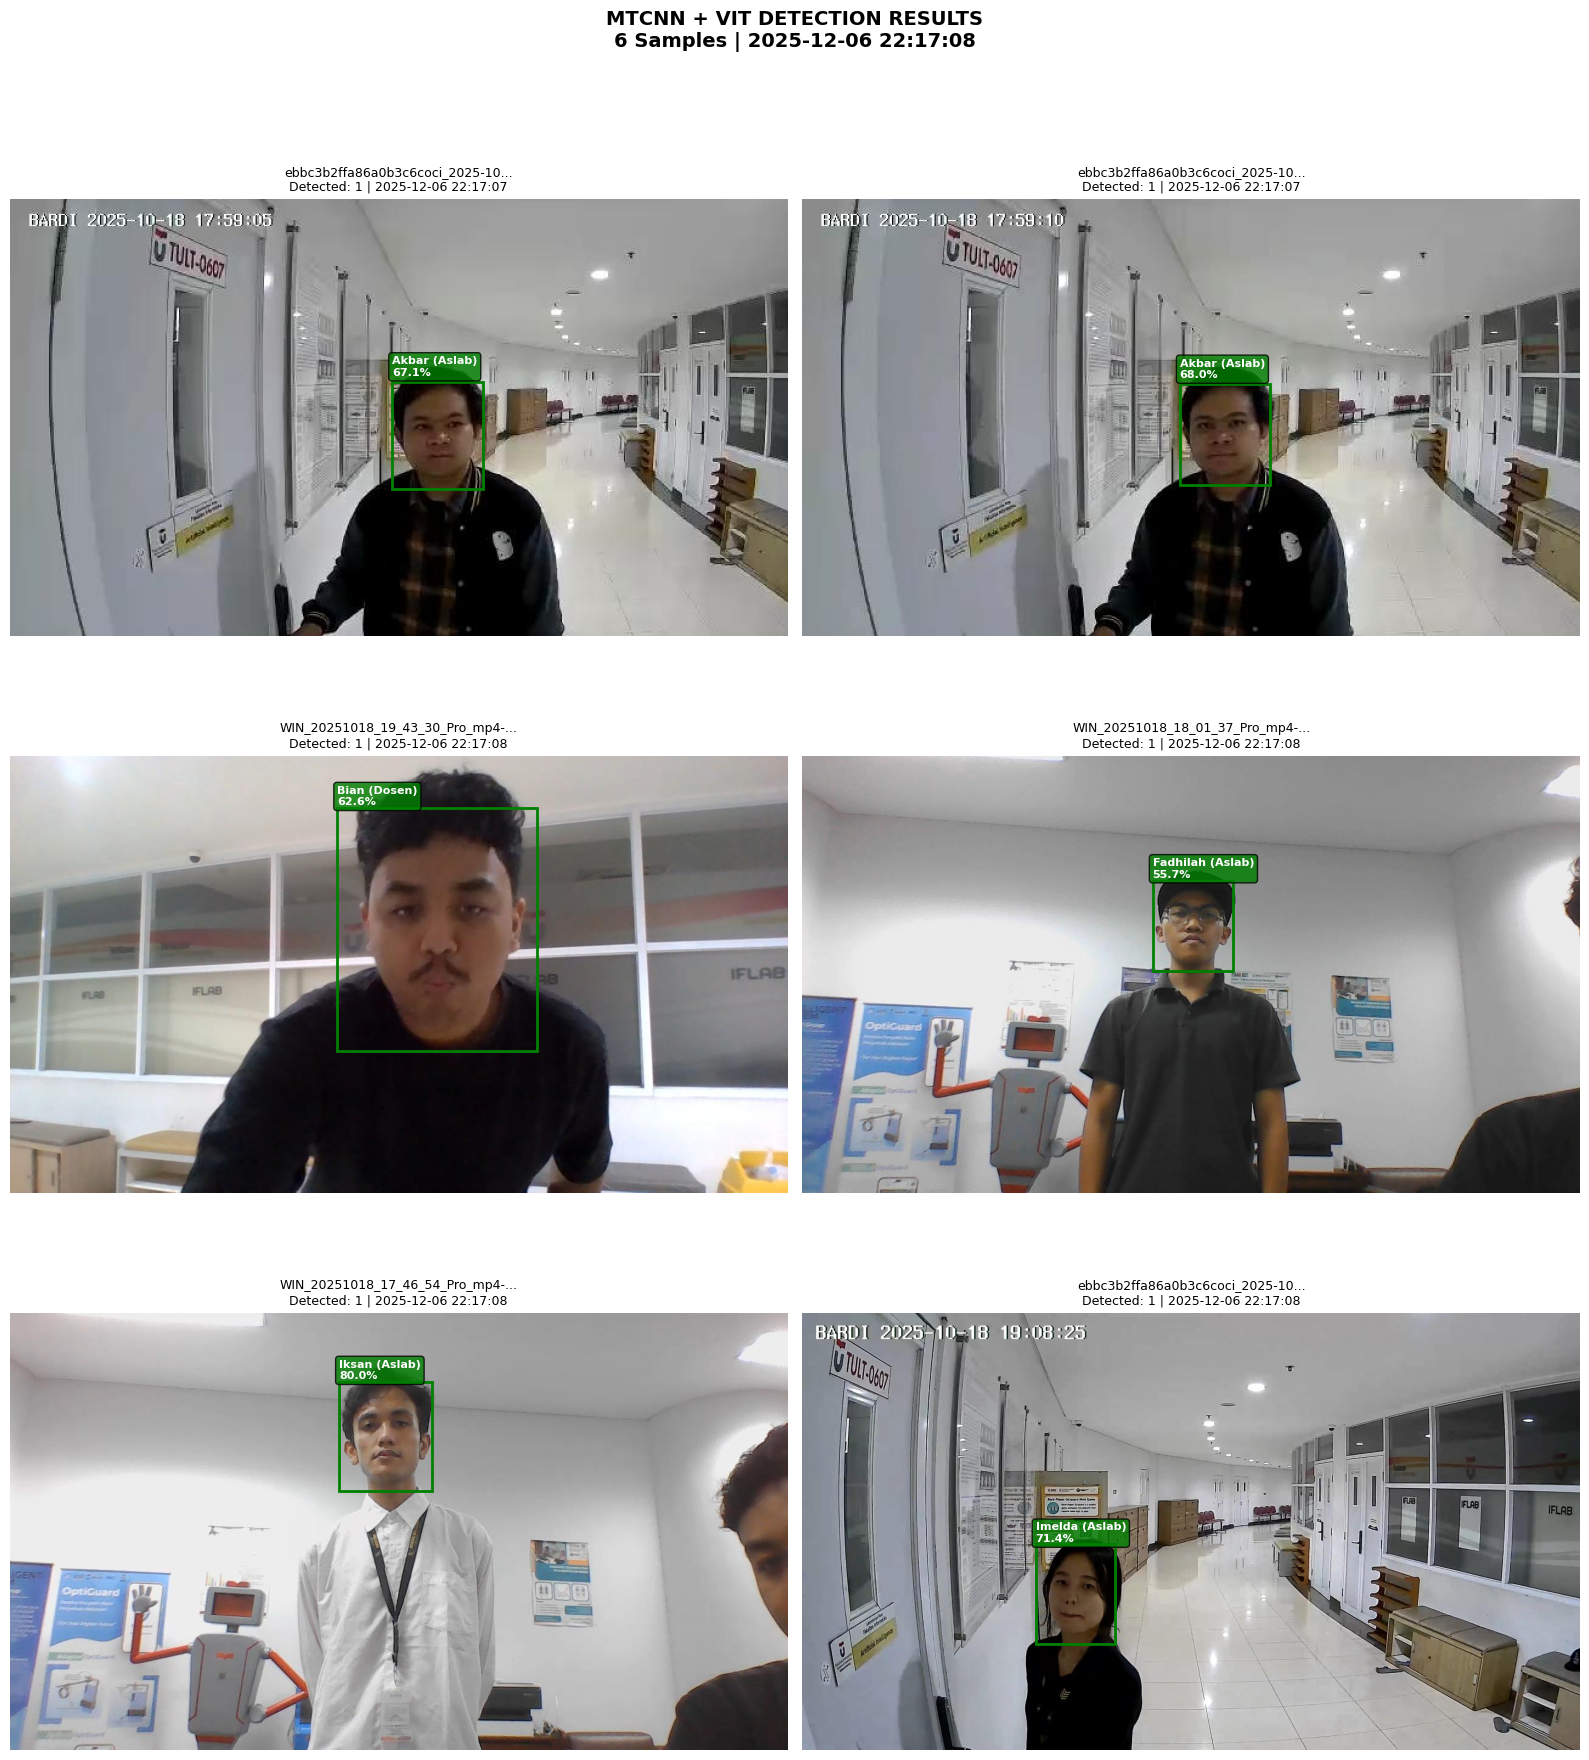


📊 Total Faces: 6 | ✅ Authorized: 6 | ❌ Guest: 0


In [48]:
"""
============================================================
CELL 15: TEST DETEKSI - MULTIPLE IMAGES
============================================================
"""

print("="*70)
print("              HASIL PERCOBAAN OBJECT DETECTION")
print("="*70)
print(f"⏰ Timestamp: {get_timestamp()}")
print("-"*70)

train_images_dir = os.path.join(dataset.location, "train")
all_test_images = [f for f in os.listdir(train_images_dir) if f.endswith('.jpg')]
num_samples = min(6, len(all_test_images))
test_samples = random.sample(all_test_images, num_samples)

cols, rows = 2, math.ceil(num_samples / 2)
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 6))
axes = axes.flatten()

all_results = []

for idx, img_name in enumerate(test_samples):
    img_path = os.path.join(train_images_dir, img_name)
    results, image, timestamp = detect_and_classify(img_path, 0.5)
    all_results.append({"image": img_name, "results": results})
    
    axes[idx].imshow(image)
    for r in results:
        x1, y1, x2, y2 = r["bbox"]
        color = "green" if r["authorized"] else "red"
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor=color, facecolor='none')
        axes[idx].add_patch(rect)
        axes[idx].text(x1, y1-5, f"{r['full_label']}\n{r['confidence']*100:.1f}%", 
                      color='white', fontsize=8, weight='bold',
                      bbox=dict(boxstyle='round', facecolor=color, alpha=0.8))
    
    axes[idx].set_title(f"{img_name[:30]}...\nDetected: {len(results)} | {timestamp}", fontsize=9)
    axes[idx].axis('off')

for idx in range(num_samples, len(axes)):
    axes[idx].axis('off')

plt.suptitle(f"MTCNN + VIT DETECTION RESULTS\n{num_samples} Samples | {get_timestamp()}", fontsize=14, weight='bold', y=1.02)
plt.tight_layout()
plt.show()

total_faces = sum(len(r["results"]) for r in all_results)
total_auth = sum(sum(1 for f in r["results"] if f["authorized"]) for r in all_results)
print(f"\n📊 Total Faces: {total_faces} | ✅ Authorized: {total_auth} | ❌ Guest: {total_faces - total_auth}")

In [49]:
"""
============================================================
CELL 16: EVALUASI MODEL - ACCURACY PER CLASS
============================================================
"""

print("="*70)
print("              EVALUASI MODEL - ACCURACY PER CLASS")
print("="*70)
print(f"⏰ Timestamp: {get_timestamp()}")
print("-"*70)

model.eval()
class_correct = defaultdict(int)
class_total = defaultdict(int)
all_preds, all_labels_list = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)
        
        for i in range(len(labels)):
            true_label = class_names[labels[i].item()]
            pred_label = class_names[predicted[i].item()]
            class_total[true_label] += 1
            if labels[i] == predicted[i]:
                class_correct[true_label] += 1
            all_preds.append(pred_label)
            all_labels_list.append(true_label)

print(f"{'No':<4} {'Class':<25} {'Correct':<10} {'Total':<10} {'Accuracy':<12} {'Status'}")
print("-"*70)

for idx, label in enumerate(class_names, 1):
    correct = class_correct[label]
    total = class_total[label]
    acc = (correct / total * 100) if total > 0 else 0
    full_label = get_full_label(label)[0]
    status = "✅ Excellent" if acc >= 90 else "🟡 Good" if acc >= 75 else "🟠 Fair" if acc >= 50 else "❌ Poor"
    print(f"{idx:<4} {full_label:<25} {correct:<10} {total:<10} {acc:.2f}%{'':<6} {status}")

overall_acc = sum(class_correct.values()) / sum(class_total.values()) * 100
print("-"*70)
print(f"{'':4} {'OVERALL':<25} {sum(class_correct.values()):<10} {sum(class_total.values()):<10} {overall_acc:.2f}%")
print("="*70)

              EVALUASI MODEL - ACCURACY PER CLASS
⏰ Timestamp: 2025-12-06 22:17:14
----------------------------------------------------------------------
No   Class                     Correct    Total      Accuracy     Status
----------------------------------------------------------------------
1    Akbar (Aslab)             41         41         100.00%       ✅ Excellent
2    Aprilianza (Aslab)        55         56         98.21%       ✅ Excellent
3    Bian (Dosen)              11         11         100.00%       ✅ Excellent
4    Fadhilah (Aslab)          32         33         96.97%       ✅ Excellent
5    Falah (Aslab)             47         47         100.00%       ✅ Excellent
6    Iksan (Aslab)             50         50         100.00%       ✅ Excellent
7    Imelda (Aslab)            33         33         100.00%       ✅ Excellent
8    Rifqy (Aslab)             36         37         97.30%       ✅ Excellent
9    Yolanda (Aslab)           25         25         100.00%       ✅ Exce

                    CONFUSION MATRIX
⏰ Timestamp: 2025-12-06 22:13:47



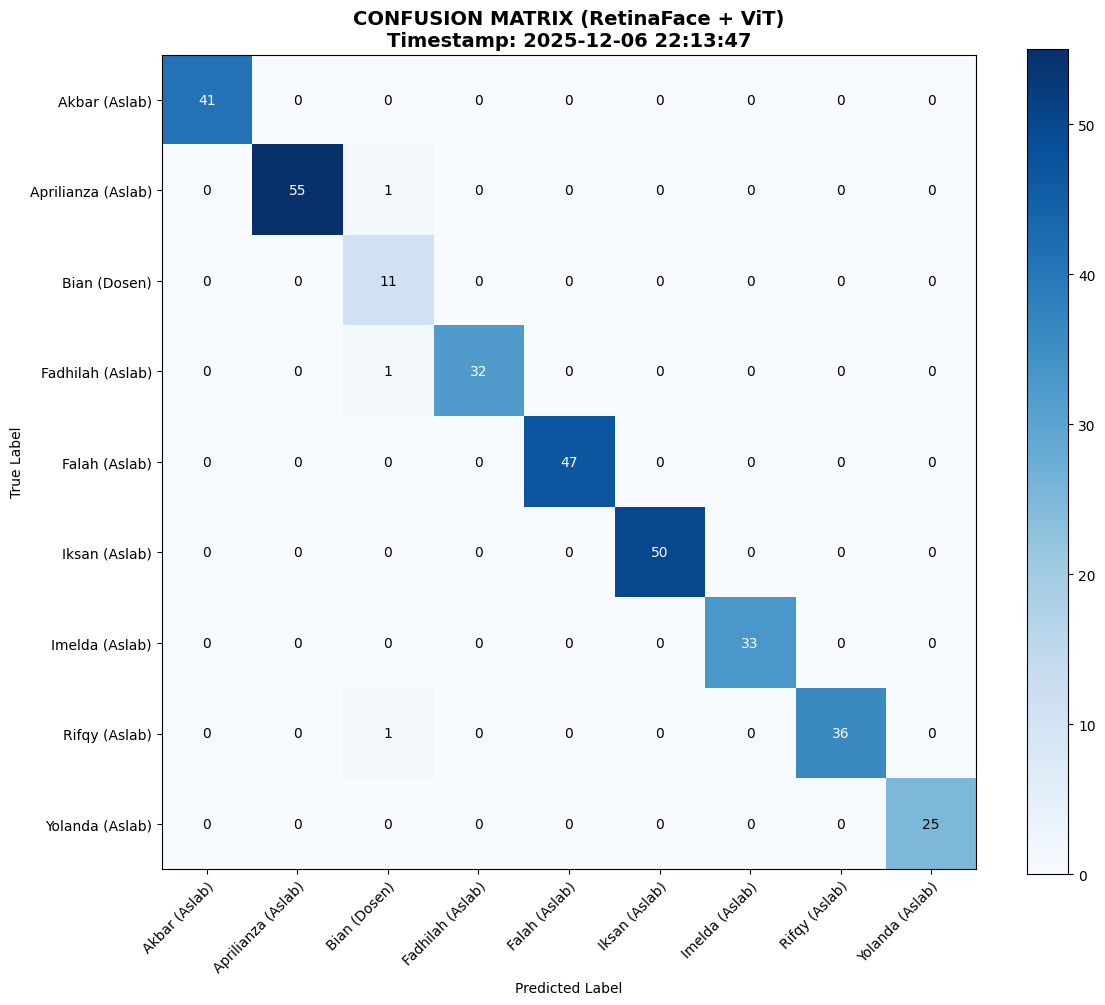


                 CLASSIFICATION REPORT
                    precision    recall  f1-score   support

     Akbar (Aslab)       1.00      1.00      1.00        41
Aprilianza (Aslab)       1.00      0.98      0.99        56
      Bian (Dosen)       0.79      1.00      0.88        11
  Fadhilah (Aslab)       1.00      0.97      0.98        33
     Falah (Aslab)       1.00      1.00      1.00        47
     Iksan (Aslab)       1.00      1.00      1.00        50
    Imelda (Aslab)       1.00      1.00      1.00        33
     Rifqy (Aslab)       1.00      0.97      0.99        37
   Yolanda (Aslab)       1.00      1.00      1.00        25

          accuracy                           0.99       333
         macro avg       0.98      0.99      0.98       333
      weighted avg       0.99      0.99      0.99       333



In [35]:
"""
============================================================
CELL 17: CONFUSION MATRIX
============================================================
"""

print("="*70)
print("                    CONFUSION MATRIX")
print("="*70)
print(f"⏰ Timestamp: {get_timestamp()}\n")

cm = confusion_matrix(all_labels_list, all_preds, labels=class_names)
display_labels = [get_full_label(l)[0] for l in class_names]

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
       xticklabels=display_labels, yticklabels=display_labels,
       ylabel='True Label', xlabel='Predicted Label')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black", fontsize=10)

ax.set_title(f'CONFUSION MATRIX (RetinaFace + ViT)\nTimestamp: {get_timestamp()}', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("                 CLASSIFICATION REPORT")
print("="*70)
print(classification_report(all_labels_list, all_preds, target_names=display_labels, zero_division=0))

              TRAINING HISTORY VISUALIZATION


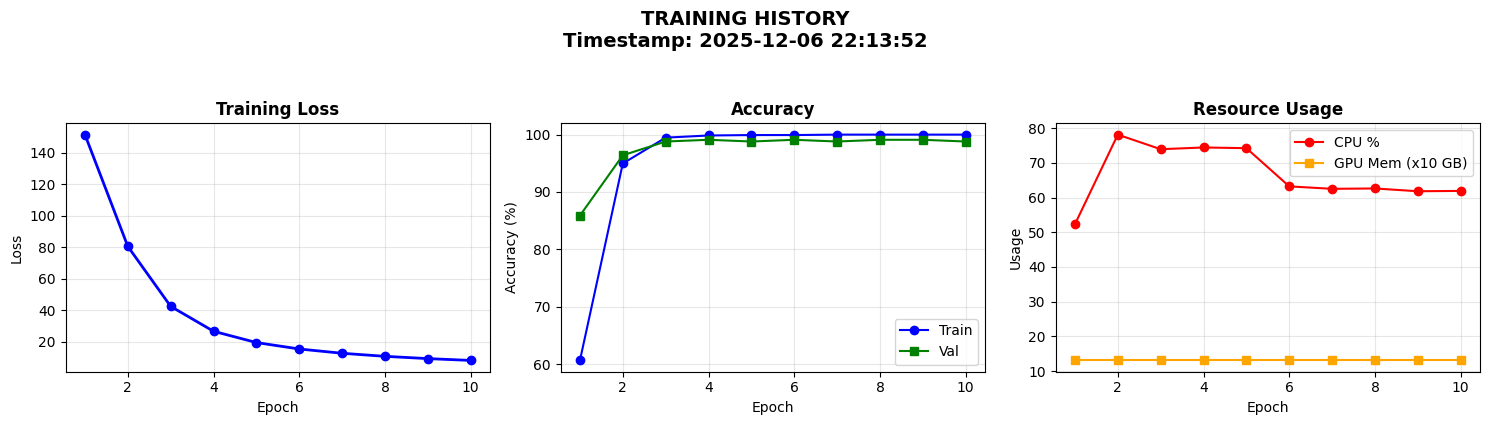


📊 Final: Train 100.0% | Val 98.8% | Best 99.1%


In [36]:
"""
============================================================
CELL 18: TRAINING HISTORY VISUALIZATION
============================================================
"""

print("="*70)
print("              TRAINING HISTORY VISUALIZATION")
print("="*70)

epochs = [h["epoch"] for h in train_history]
train_losses = [h["train_loss"] for h in train_history]
train_accs = [h["train_acc"] for h in train_history]
val_accs = [h["val_acc"] for h in train_history]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(epochs, train_losses, 'b-o', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss', weight='bold')
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs, train_accs, 'b-o', label='Train')
axes[1].plot(epochs, val_accs, 'g-s', label='Val')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy', weight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Resource Usage
cpu_usage = [h["cpu"] for h in train_history]
gpu_mem = [h["gpu_mem"] for h in train_history]
axes[2].plot(epochs, cpu_usage, 'r-o', label='CPU %')
axes[2].plot(epochs, [g*10 for g in gpu_mem], 'orange', marker='s', label='GPU Mem (x10 GB)')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Usage')
axes[2].set_title('Resource Usage', weight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle(f"TRAINING HISTORY\nTimestamp: {get_timestamp()}", fontsize=14, weight='bold', y=1.05)
plt.tight_layout()
plt.show()

print(f"\n📊 Final: Train {train_accs[-1]:.1f}% | Val {val_accs[-1]:.1f}% | Best {best_val_acc:.1f}%")

              SAMPLE PREDIKSI BENAR VS SALAH


Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.


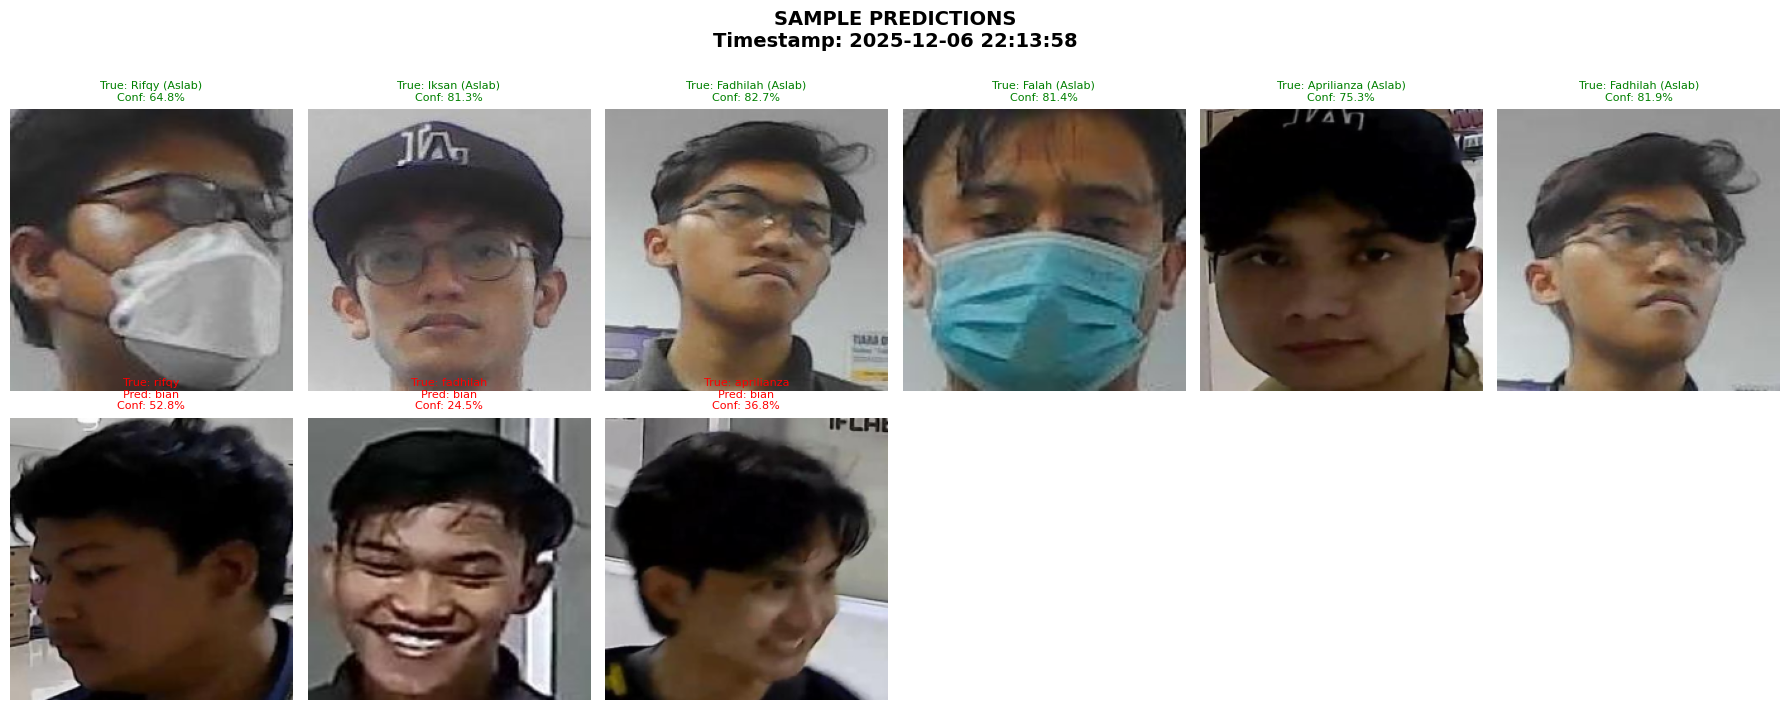

✅ Correct: 6 | ❌ Incorrect: 3


In [37]:
"""
============================================================
CELL 19: SAMPLE PREDIKSI BENAR VS SALAH
============================================================
"""

print("="*70)
print("              SAMPLE PREDIKSI BENAR VS SALAH")
print("="*70)

correct_samples, incorrect_samples = [], []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images_d = images.to(device)
        outputs = model(images_d).logits
        probs = torch.softmax(outputs, dim=1)
        confs, preds = torch.max(probs, 1)
        
        for i in range(len(labels)):
            sample = {"image": images[i], "true": class_names[labels[i].item()],
                     "pred": class_names[preds[i].item()], "conf": confs[i].item()}
            if labels[i] == preds[i] and len(correct_samples) < 6:
                correct_samples.append(sample)
            elif labels[i] != preds[i] and len(incorrect_samples) < 6:
                incorrect_samples.append(sample)

fig, axes = plt.subplots(2, 6, figsize=(18, 7))

for idx in range(6):
    if idx < len(correct_samples):
        s = correct_samples[idx]
        img = s["image"].permute(1,2,0).numpy()
        img = (img * 0.5 + 0.5).clip(0, 1)
        axes[0, idx].imshow(img)
        axes[0, idx].set_title(f"True: {get_full_label(s['true'])[0]}\nConf: {s['conf']*100:.1f}%", fontsize=8, color='green')
    axes[0, idx].axis('off')

for idx in range(6):
    if idx < len(incorrect_samples):
        s = incorrect_samples[idx]
        img = s["image"].permute(1,2,0).numpy()
        img = (img * 0.5 + 0.5).clip(0, 1)
        axes[1, idx].imshow(img)
        axes[1, idx].set_title(f"True: {s['true']}\nPred: {s['pred']}\nConf: {s['conf']*100:.1f}%", fontsize=8, color='red')
    axes[1, idx].axis('off')

axes[0, 0].set_ylabel("✅ CORRECT", fontsize=12, weight='bold', color='green', rotation=0, labelpad=50, va='center')
axes[1, 0].set_ylabel("❌ WRONG", fontsize=12, weight='bold', color='red', rotation=0, labelpad=50, va='center')

plt.suptitle(f"SAMPLE PREDICTIONS\nTimestamp: {get_timestamp()}", fontsize=14, weight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"✅ Correct: {len(correct_samples)} | ❌ Incorrect: {len(incorrect_samples)}")

In [31]:
"""
============================================================
CELL 20: SUMMARY & INFO
============================================================
"""

print("="*70)
print("                         SUMMARY")
print("="*70)
print(f"⏰ Timestamp: {get_timestamp()}")
print("-"*70)
print(f"""
📌 MODEL INFO:
   - Face Detection : RetinaFace (State-of-the-art)
   - Classification : ViT (google/vit-base-patch16-224-in21k)
   - Device         : {device}
   - Best Val Acc   : {best_val_acc:.2f}%

📌 DATASET:
   - Total Classes  : {num_classes}
   - Train Size     : {train_size}
   - Val Size       : {val_size}

📌 PERSONNEL:
""")

for nama, role in ROLE_MAPPING.items():
    status = "✅" if role != "Guest" else "❌"
    print(f"   {status} {nama.capitalize():<15} - {role}")

print(f"""
📌 FILES SAVED:
   - best_vit_retinaface.pth
   - {MODEL_DIR}/model.pth
   - {MODEL_DIR}/config.json

📌 KEUNGGULAN RETINAFACE vs MTCNN:
   ✅ Lebih akurat untuk wajah kecil
   ✅ Lebih baik untuk wajah miring/rotated
   ✅ Deteksi facial landmarks lebih presisi
   ✅ Multi-scale detection
""")
print("="*70)

                         SUMMARY
⏰ Timestamp: 2025-12-06 22:12:26
----------------------------------------------------------------------

📌 MODEL INFO:
   - Face Detection : RetinaFace (State-of-the-art)
   - Classification : ViT (google/vit-base-patch16-224-in21k)
   - Device         : cuda
   - Best Val Acc   : 99.10%

📌 DATASET:
   - Total Classes  : 9
   - Train Size     : 1331
   - Val Size       : 333

📌 PERSONNEL:

   ✅ Iksan           - Aslab
   ✅ Akbar           - Aslab
   ✅ Aprilianza      - Aslab
   ✅ Bian            - Dosen
   ✅ Fadhilah        - Aslab
   ✅ Falah           - Aslab
   ✅ Imelda          - Aslab
   ✅ Rifqy           - Aslab
   ✅ Yolanda         - Aslab

📌 FILES SAVED:
   - best_vit_retinaface.pth
   - vit_mtcnn_model/model.pth
   - vit_mtcnn_model/config.json

📌 KEUNGGULAN RETINAFACE vs MTCNN:
   ✅ Lebih akurat untuk wajah kecil
   ✅ Lebih baik untuk wajah miring/rotated
   ✅ Deteksi facial landmarks lebih presisi
   ✅ Multi-scale detection



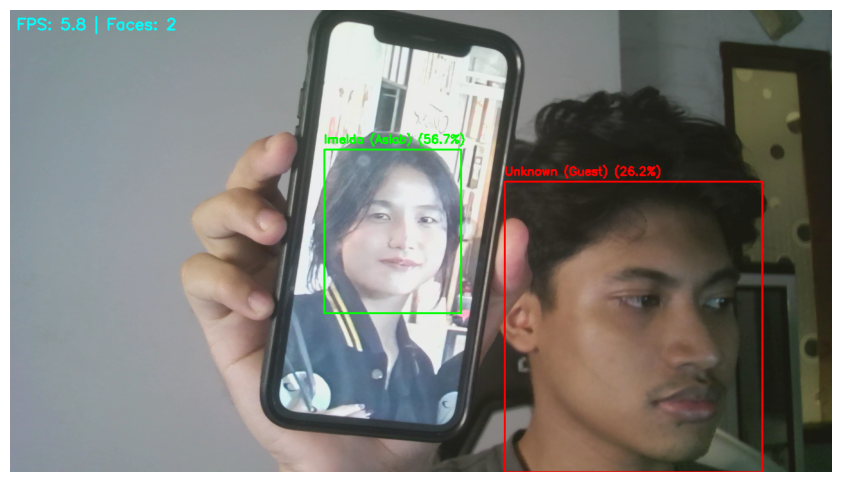

In [ ]:
"""
============================================================
CELL: WEBCAM INFERENCE - JUPYTER NOTEBOOK SAFE VERSION
============================================================
DIJALANKAN DI NOTEBOOK TANPA cv2.imshow()
============================================================
"""

import cv2
import torch
import os
from datetime import datetime
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

print("=" * 60)
print("         WEBCAM INFERENCE - MTCNN + ViT (Notebook Safe)")
print("=" * 60)
print("📹 Press Stop Button (kernel) to stop webcam loop")
print("=" * 60)


def process_webcam_frame(frame):
    """Process single frame: detect faces and classify"""
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(rgb_frame)

    boxes, probs = mtcnn.detect(pil_image)
    results = []

    if boxes is None:
        return rgb_frame, results

    for box, prob in zip(boxes, probs):
        if prob is None or prob < 0.7:
            continue

        x1, y1, x2, y2 = map(int, box)
        w, h = x2 - x1, y2 - y1
        pad = int(max(w, h) * 0.15)
        x1 = max(0, x1 - pad)
        y1 = max(0, y1 - pad)
        x2 = min(pil_image.size[0], x2 + pad)
        y2 = min(pil_image.size[1], y2 + pad)

        face = pil_image.crop((x1, y1, x2, y2))
        face_tensor = transform(face).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(face_tensor).logits
            probs_cls = torch.softmax(outputs, 1)
            confidence, predicted = torch.max(probs_cls, 1)

        confidence = confidence.item()

        if confidence >= 0.5:
            name = class_names[predicted.item()]
            full_label, role, authorized = get_full_label(name)
        else:
            full_label = "Unknown (Guest)"
            authorized = False

        color = (0, 255, 0) if authorized else (255, 0, 0)

        # Draw bounding box & labels
        cv2.rectangle(rgb_frame, (x1, y1), (x2, y2), color, 2)

        label_text = f"{full_label} ({confidence*100:.1f}%)"
        cv2.putText(rgb_frame, label_text, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        results.append({
            "name": full_label,
            "confidence": confidence,
            "authorized": authorized
        })

    return rgb_frame, results


# Open webcam
cap = cv2.VideoCapture(0)
cap.set(3, 1280)
cap.set(4, 720)

if not cap.isOpened():
    print("❌ Error: Webcam tidak terbuka")
else:
    print("✅ Webcam opened successfully!")
    print("⚠ Loop akan berjalan sampai kamu menekan STOP (interrupt kernel).")

    frame_count = 0
    start_time = datetime.now()

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        processed_frame, results = process_webcam_frame(frame)

        frame_count += 1
        elapsed = (datetime.now() - start_time).total_seconds()
        fps = frame_count / elapsed if elapsed else 0

        # Draw FPS
        cv2.putText(processed_frame, f"FPS: {fps:.1f} | Faces: {len(results)}",
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)

        # Display on Jupyter cell
        clear_output(wait=True)
        plt.figure(figsize=(12, 6))
        plt.imshow(processed_frame)
        plt.axis("off")
        plt.show()

cap.release()
print("\nWebcam Stop.")
